In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport graph
%aimport hyper
%aimport vlgp

In [2]:
import os.path as op
import numpy as np
import scipy as sp
from scipy.special import expit
from scipy import stats
from scipy import linalg
from scipy.io import loadmat, savemat
from scipy.linalg import orth, svd
from numpy.linalg import norm
from numpy import dstack, rollaxis
from sklearn.decomposition.factor_analysis import FactorAnalysis
import h5py
import pickle

import simulation, util, graph, hyper, vlgp
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

In [3]:
# Setup graphics
sns.set(font_scale=1.5)
sns.set_style("white")
samplepath = op.expanduser("~/data/sample")
outputpath = op.expanduser("~/data/output")
figurepath = op.expanduser("~/data/figure")

In [4]:
# Graf_5 = loadmat(op.join(samplepath, 'Graf_5.mat'), squeeze_me=True)
Graf_5 = h5py.File(op.join(samplepath, 'Graf_5.mat'), 'r')

In [5]:
Graf_5['ori'].shape, Graf_5['y'].shape

((3600, 1), (148, 2560, 3600))

In [24]:
orient = np.squeeze(np.array(Graf_5['ori']))
unique_ori = np.unique(orient)
y = np.array(Graf_5['y'])
# transpose y (into trial, time, neuron)
y = np.transpose(y, axes=(2, 1, 0))

In [7]:
# extract trials orienting at 0 and 90 deg
y0 = y[ori == 0, :, :]
y90 = y[ori == 90, :, :]

In [8]:
# combine trials of 0 and 90 deg
y4fit = np.concatenate((y0, y90), axis=0)

In [9]:
# load previous hyperparameter
vLGP_4D = loadmat(op.join(outputpath, 'Graf_vLGP_4D.mat'), squeeze_me=True)['Graf_vLGP_4D']
omega = vLGP_4D['omega'].tolist()
print(omega)

[ 0.00016897  0.00021241  0.000177    0.00013326]


In [ ]:
nlatent = 4 # 4D latent
np.random.seed(0)
sigma = np.full(nlatent, fill_value=1.0)
fit_0_90_4D = vlgp.fit(y4fit, ['spike'] * y4fit.shape[-1], sigma, omega, lag=2, rank=100, 
               niter=50, tol=1e-5, verbose=True, nadjhess=100, 
               nhyper=3, learn_sigma=False, learn_omega=False, adjhess=True)
savemat(op.join(outputpath, 'Graf_5_0_90_vLGP_4D_Feb15_1'), fit_0_90_4D)


Inference starts

[1]
sigma: [ 1.  1.  1.  1.]
Elapsed Post: 23.263530244119465
Elapsed Param: 292.4820277253166
omega: [ 0.00016897  0.00021241  0.000177    0.00013326]
Elapsed Total: 322.16897252667695
LL: -23464815.71787972
ELBO: -23508529.48818931

[2]
sigma: [ 1.  1.  1.  1.]
Elapsed Post: 23.27285592444241
Elapsed Param: 288.15161112044007
omega: [ 0.00016897  0.00021241  0.000177    0.00013326]
Elapsed Total: 317.8201730372384
LL: -16871467.01073946
ELBO: -16908830.987579733

[3]
sigma: [ 1.  1.  1.  1.]
Elapsed Post: 23.37835439760238
Elapsed Param: 287.8290144549683
omega: [ 0.00016897  0.00021241  0.000177    0.00013326]
Elapsed Total: 317.65139962825924
LL: -13251757.330350766
ELBO: -13286984.166380893

[4]
sigma: [ 1.  1.  1.  1.]
Elapsed Post: 23.35961125511676
Elapsed Param: 286.48789832461625
omega: [ 0.00016897  0.00021241  0.000177    0.00013326]
Elapsed Total: 316.0092331795022
LL: -10979191.099678019
ELBO: -11011972.918580063

[5]
sigma: [ 1.  1.  1.  1.]
Elapsed Po

In [11]:
fit_0_90_4D = loadmat(op.join(outputpath, 'Graf_5_0_90_vLGP_4D_2'), squeeze_me=True)

In [12]:
np.random.seed(0)
sigma = np.full(4, fill_value=1.0)
for trial in range(y.shape[0]):
    fit = vlgp.fit(y[[trial], :], ['spike'] * y.shape[-1], sigma, omega, a=fit_0_90_4D['a'], b=fit_0_90_4D['b'], 
                          lag=2, rank=100, 
               niter=50, tol=1e-5, verbose=False, nadjhess=100, infer='posterior',
               nhyper=3, learn_sigma=False, learn_omega=False, adjhess=True)
    with open(op.join(outputpath, 'Graf_5_vLGP_4D_t{}.dat'.format(trial + 1)), 'wb') as outfile:
        pickle.dump(fit, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    %xdel fit

In [13]:
latent = []
for trial in range(y.shape[0]):
    fit = pickle.load(open(op.join(outputpath, 'Graf_5_vLGP_4D_{:d}deg.dat'.format(trial + 1)), 'rb'))
    latent.append(fit['mu'])
    %xdel fit

In [18]:
mu = np.concatenate(latent)

In [20]:
savemat(op.join(outputpath, 'Graf_5_vLGP_4D'), {'mu':mu})

In [21]:
with open(op.join(outputpath, 'Graf_5_vLGP_4D.dat'), 'wb') as outfile:
    pickle.dump(mu, outfile, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
np.random.seed(0)
sigma = np.full(4, fill_value=1.0)

for ori in unique_ori:
    fit = vlgp.fit(y[orient == ori, :], ['spike'] * y.shape[-1], sigma, omega, a=fit_0_90_4D['a'], b=fit_0_90_4D['b'], 
               lag=2, rank=100, niter=50, tol=1e-5, verbose=False, infer='posterior', 
               learning_rate=1, nhyper=3, learn_sigma=False, learn_omega=False, adjhess=True, decay=0)
    with open(op.join(outputpath, 'Graf5_vLGP_4D_{:d}deg.dat'.format(int(ori))), 'wb') as outfile:
        pickle.dump(fit, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    %xdel fit

In [45]:
latent = []
for ori in unique_ori:
    fit = pickle.load(open(op.join(outputpath, 'Graf5_vLGP_4D_{:d}deg.dat'.format(int(ori))), 'rb'))
    latent.append(fit['mu'])
    %xdel fit
mu = np.concatenate(latent)
print(mu.shape)
with open(op.join(outputpath, 'Graf5_vLGP_4D.dat'), 'wb') as outfile:
    pickle.dump(mu, outfile, protocol=pickle.HIGHEST_PROTOCOL)

(3600, 2560, 4)


In [42]:
fit = vlgp.fit(y[orient==0, :], ['spike'] * y.shape[-1], sigma, omega, a=fit_0_90_4D['a'], b=fit_0_90_4D['b'], 
               lag=2, rank=100, niter=50, tol=1e-5, verbose=True, infer='posterior', 
               learning_rate=1, nhyper=3, learn_sigma=False, learn_omega=False, adjhess=True, decay=0)


Inference starts

[1]
LL: -1278697.5420241188
Elapsed Post: 11.146120415069163
Elapsed Total: 13.790832066908479
sigma: [ 1.  1.  1.  1.]
Elapsed Param: 8.642673492431641e-07
ELBO: -1286508.3379965445
omega: [ 0.00016897  0.00021241  0.000177    0.00013326]

[2]
LL: -1218673.60145715
Elapsed Post: 10.596423401497304
Elapsed Total: 13.150362971238792
sigma: [ 1.  1.  1.  1.]
Elapsed Param: 9.434297680854797e-07
ELBO: -1225496.4524865125
omega: [ 0.00016897  0.00021241  0.000177    0.00013326]

[3]
LL: -1189975.5694472913
Elapsed Post: 10.50957282166928
Elapsed Total: 13.067348640412092
sigma: [ 1.  1.  1.  1.]
Elapsed Param: 2.6794150471687317e-06
ELBO: -1197523.622069134
omega: [ 0.00016897  0.00021241  0.000177    0.00013326]

[4]
LL: -1175183.9995840783
Elapsed Post: 10.431489796377718
Elapsed Total: 13.008039047010243
sigma: [ 1.  1.  1.  1.]
Elapsed Param: 1.5245750546455383e-06
ELBO: -1183925.8546089614
omega: [ 0.00016897  0.00021241  0.000177    0.00013326]

[5]
LL: -1166747.23

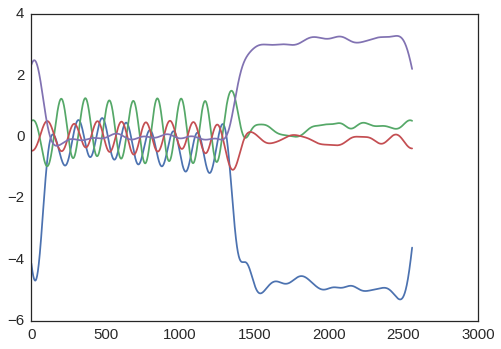

In [43]:
plt.plot(fit['mu'].mean(axis=0));